<a href="https://colab.research.google.com/github/fani-01/Smart-Sorting-Transfer-Learning-for-Identifying-Rotten-Fruits-and-Vegetables/blob/main/healthy_vs_rotten_h5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf



In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phanithkumarchinta","key":"43f6c459825c21ec1659528edfca7466"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten

Dataset URL: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
License(s): CC0-1.0
 99% 4.74G/4.77G [01:18<00:02, 15.5MB/s]
100% 4.77G/4.77G [01:18<00:00, 65.2MB/s]


In [5]:
!unzip fruit-and-vegetable-disease-healthy-vs-rotten.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (85).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (86).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (87).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (88).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (89).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (9).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (90).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (91).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (92).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (93).jpg  
  inflating: Fruit And Vegetable Diseases Dataset/Potato__He

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = '/content/Fruit And Vegetable Diseases Dataset'
output_dir = 'output_dataset'
valid_extensions = ('.jpg', '.jpeg', '.png')

classes = os.listdir(dataset_dir)

os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    if not os.path.isdir(class_dir):
        continue

    os.makedirs(os.path.join(output_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', cls), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test', cls), exist_ok=True)

    images = [img for img in sorted(os.listdir(class_dir)) if img.lower().endswith(valid_extensions)][:200]

    train_val_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=0.25, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))

    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))

    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'test', cls, img))

    print(f"{cls}: Total={len(images)}, Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

print("✅ Dataset successfully split into training, validation, and test sets.")


Cucumber__Rotten: Total=200, Train=120, Val=40, Test=40
Strawberry__Healthy: Total=200, Train=120, Val=40, Test=40
Potato__Rotten: Total=200, Train=120, Val=40, Test=40
Strawberry__Rotten: Total=200, Train=120, Val=40, Test=40
Jujube__Healthy: Total=200, Train=120, Val=40, Test=40
Apple__Rotten: Total=200, Train=120, Val=40, Test=40
Grape__Rotten: Total=200, Train=120, Val=40, Test=40
Mango__Rotten: Total=200, Train=120, Val=40, Test=40
Potato__Healthy: Total=200, Train=120, Val=40, Test=40
Orange__Rotten: Total=200, Train=120, Val=40, Test=40
Bellpepper__Healthy: Total=200, Train=120, Val=40, Test=40
Pomegranate__Healthy: Total=200, Train=120, Val=40, Test=40
Banana__Healthy: Total=200, Train=120, Val=40, Test=40
Mango__Healthy: Total=200, Train=120, Val=40, Test=40
Tomato__Healthy: Total=200, Train=120, Val=40, Test=40
Grape__Healthy: Total=200, Train=120, Val=40, Test=40
Banana__Rotten: Total=200, Train=120, Val=40, Test=40
Orange__Healthy: Total=200, Train=120, Val=40, Test=40
Guav

In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_dir = '/content/output_dataset'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)


Found 3360 images belonging to 28 classes.
Found 1120 images belonging to 28 classes.
Found 1120 images belonging to 28 classes.
{'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}
{'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'G

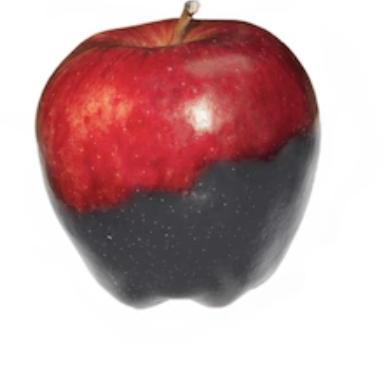

In [8]:
import os
import random
from IPython.display import Image, display
folder_path = '/content/output_dataset/train/Apple__Rotten'
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_image = random.choice(image_files)
image_path = os.path.join(folder_path, selected_image)
display(Image(filename=image_path))


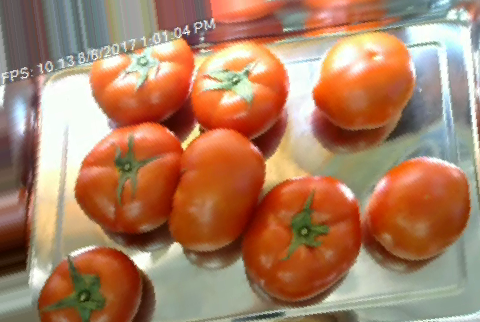

In [9]:
import os
import random
from IPython.display import Image, display
folder_path = '/content/output_dataset/train/Tomato__Healthy'
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_image = random.choice(image_files)
image_path = os.path.join(folder_path, selected_image)
display(Image(filename=image_path))


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/output_dataset/train'
test_dir = '/content/output_dataset/test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3360 images belonging to 28 classes.
Found 1120 images belonging to 28 classes.


In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

vgg = VGG16(include_top=False, input_shape=(224, 224, 3))

for layer in vgg.layers:
    print(layer)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
output = Dense(28, activation='softmax')(x)

vgg16 = Model(vgg.input, output)

vgg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<MaxPooling2D name=block5_pool, built=True>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │       702,492 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,417,180 (58.81 MB)

 Trainable params: 702,492 (2.68 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

vgg16.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

history = vgg16.fit(
    train,
    validation_data=test,
    epochs=15,
    steps_per_epoch=20,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.2328 - loss: 3.3548 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1202s 62s/step - accuracy: 0.2382 - loss: 3.3304 - val_accuracy: 0.5063 - val_loss: 1.7159
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1199s 62s/step - accuracy: 0.5955 - loss: 1.5038 - val_accuracy: 0.6643 - val_loss: 1.1807
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1200s 62s/step - accuracy: 0.7505 - loss: 0.8725 - val_accuracy: 0.7723 - val_loss: 0.7886
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1242s 64s/step - accuracy: 0.8584 - loss: 0.5346 - val_accuracy: 0.7866 - val_loss: 0.7821
Epoch 5/15
11/20 ━━━━━━━━━━━━━━━━━━━━ 3:19 22s/step - accuracy: 0.8822 - loss: 0.4821

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1236s 64s/step - accuracy: 0.8824 - loss: 0.4764 - val_accuracy: 0.7893 - val_loss: 0.7351
Epoch 6/15
 5/20 ━━━━━━━━━━━━━━━━━━━━ 5:17 21s/step - accuracy: 0.9234 - loss: 0.3695

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 851s 44s/step - accuracy: 0.9105 - loss: 0.3625 - val_accuracy: 0.7804 - val_loss: 0.8160
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1176s 61s/step - accuracy: 0.8855 - loss: 0.4289 - val_accuracy: 0.7643 - val_loss: 0.8465
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1188s 61s/step - accuracy: 0.9017 - loss: 0.3271 - val_accuracy: 0.8179 - val_loss: 0.6490
Epoch 9/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1163s 60s/step - accuracy: 0.9529 - loss: 0.2186 - val_accuracy: 0.8045 - val_loss: 0.6585
Epoch 10/15
 4/20 ━━━━━━━━━━━━━━━━━━━━ 5:40 21s/step - accuracy: 0.9212 - loss: 0.3298

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1224s 63s/step - accuracy: 0.9232 - loss: 0.3093 - val_accuracy: 0.8036 - val_loss: 0.7012
Epoch 11/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1166s 60s/step - accuracy: 0.9519 - loss: 0.2268 - val_accuracy: 0.8098 - val_loss: 0.6525


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train = datagen.flow_from_directory(
    '/content/output_dataset',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

test = datagen.flow_from_directory(
    '/content/output_dataset',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

Found 4480 images belonging to 3 classes.
Found 1120 images belonging to 3 classes.


In [14]:
import os

# List class folders under 'train'
print("Folders inside /train:")
print(os.listdir('/content/output_dataset/train'))

# List images inside the correct Strawberry folder (with two underscores)
print("\nFiles inside Strawberry folder:")
print(os.listdir('/content/output_dataset/train/Strawberry__Rotten'))


Folders inside /train:
['Cucumber__Rotten', 'Strawberry__Healthy', 'Potato__Rotten', 'Strawberry__Rotten', 'Jujube__Healthy', 'Apple__Rotten', 'Grape__Rotten', 'Mango__Rotten', 'Potato__Healthy', 'Orange__Rotten', 'Bellpepper__Healthy', 'Pomegranate__Healthy', 'Banana__Healthy', 'Mango__Healthy', 'Tomato__Healthy', 'Grape__Healthy', 'Banana__Rotten', 'Orange__Healthy', 'Guava__Healthy', 'Bellpepper__Rotten', 'Apple__Healthy', 'Carrot__Healthy', 'Pomegranate__Rotten', 'Jujube__Rotten', 'Tomato__Rotten', 'Cucumber__Healthy', 'Guava__Rotten', 'Carrot__Rotten']

Files inside Strawberry folder:
['143.jpg', '131.jpg', '156.jpg', '15.jpg', '229.jpg', '128.jpg', '135.jpg', '173.jpg', '165.jpg', '268.jpg', '219.jpg', '121.jpg', '188.jpg', '254.jpg', '199.jpg', '161.jpg', '234.jpg', '270.jpg', '24.jpg', '19.jpg', '104.jpg', '2.jpg', '239.jpg', '150.jpg', '18.jpg', '276.jpg', '119.jpg', '204.jpg', '126.jpg', '134.jpg', '218.jpg', '122.jpg', '272.jpg', '248.jpg', '123.jpg', '256.jpg', '271.jpg', '

In [15]:
import numpy as np
import random
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Path to the folder
folder = '/content/output_dataset/train/Strawberry__Rotten'

# Randomly select an image
file = random.choice(os.listdir(folder))
img_path = os.path.join(folder, file)

print("Testing image:", img_path)

# Load and preprocess the image
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Predict using your trained VGG16 model
preds = vgg16.predict(x)

# Assuming you have a label list like this (adjust based on your actual class labels)
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

# Output prediction
predicted_class = labels[np.argmax(preds)]
print("Predicted class index:", predicted_class)


Testing image: /content/output_dataset/train/Strawberry__Rotten/118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
Predicted class index: 5


In [16]:
img_path = '/content/output_dataset/train/Strawberry__Rotten/228.jpg'
import numpy as np
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)
preds = vgg16.predict(np.array([x]))
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.12381455e-32,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 3.71345943e-34,
        0.00000000e+00, 3.31566261e-31, 6.91897204e-26, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.08130544e-35, 0.00000000e+00, 0.00000000e+00,
        1.25962540e-33, 5.33196057e-12, 1.10051263e-29, 0.00000000e+00]],
      dtype=float32)

In [19]:
labels[np.argmax(preds)]

5

In [27]:
import os
os.listdir()


['.config',
 'Fruit And Vegetable Diseases Dataset',
 'kaggle.json',
 'output_dataset',
 'fruit-and-vegetable-disease-healthy-vs-rotten.zip',
 'sample_data']

In [32]:
vgg16.save('healthy_vs_rotten.h5')


In [33]:
model = tf.keras.models.load_model('healthy_vs_rotten.h5')


In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
